In [1]:
%matplotlib inline

from fipy import CellVariable, DiffusionTerm, Grid2D, parallelComm, TransientTerm, Variable, Viewer
from fipy.tools import dump, numerix
import numpy as np

In [2]:
# Numerical parameters
nx = ny = 400         # domain size
dx = dy = 0.25        # mesh resolution
dt = Variable(0.1) # initial timestep

In [3]:
# Physical parameters
mm = 4.               # anisotropic symmetry
epsilon_m = 0.025     # degree of anisotropy
theta_0 = 0.0         # tilt w.r.t. x-axis
tau_0 = 1.            # numerical mobility
DD = 10.              # thermal diffusivity
W_0 = 1.              # isotropic well height
lamda = DD * tau_0 / 0.6267 / W_0**2
delta = 0.05          # undercooling

In [4]:
# Mesh and field variables
mesh = Grid2D(nx=nx, ny=ny, dx=dx, dy=dy)
phase = CellVariable(mesh=mesh, hasOld=True)
uu = CellVariable(mesh=mesh, hasOld=True)
uu.constrain(-delta, mesh.exteriorFaces)

In [5]:
def initialize():
    phase[:] = -1.0
    x, y = mesh.cellCenters
    radius = 4.0 # Initial r=1 collapses due to Gibbs-Thomson, r=2 slumps to phi=0.6, r=4 seems OK.
    center = (nx * dx / 2., ny * dy / 2.)
    mask = (x - center[0])**2 + (y - center[1])**2 < radius**2
    phase.setValue(1., where=mask)
    uu[:] = -delta

initialize()

In [6]:
def make_tau(phase_):
    theta_cell = numerix.arctan2(phase_.grad[1], phase_.grad[0])
    a_cell = 1 + epsilon_m * numerix.cos(mm * theta_cell + theta_0)
    return tau_0 * a_cell**2

tau = make_tau(phase)
tau_old = make_tau(phase.old)

In [7]:
source = (phase - lamda * uu * (1 - phase**2)) * (1 - phase**2)

In [8]:
theta = numerix.arctan2(phase.faceGrad[1], phase.faceGrad[0])
W = W_0 * (1 + epsilon_m * numerix.cos(mm * theta - theta_0))

W_theta = - W_0 * mm * epsilon_m * numerix.sin(mm * theta - theta_0)

In [9]:
# Build up the diffusivity matrix
I0 = Variable(value=((1,0), (0,1)))
I1 = Variable(value=((0,-1), (1,0)))
Dphase = W**2 * I0 + W * W_theta * I1

In [10]:
heat_eqn = TransientTerm() == DiffusionTerm(DD) + (phase - phase.old) / dt / 2.

phase_eqn = TransientTerm(tau) == DiffusionTerm(Dphase) + source

initialize()

In [11]:
solid_area = (np.array(phase.globalValue)>0).sum()*dx*dy # initial size of solid nucleus
if parallelComm.procID==0:
    print 'solid area', solid_area

solid area 50.75


In [12]:
# Serial:
from fipy.solvers.pysparse import LinearLUSolver as Solver
solver_heat = Solver()
solver_phase = Solver()

## Parallel: mpirun with --trilinos for proper meshing, etc.
#from fipy.solvers.trilinos import LinearGMRESSolver as Solver
#solver_heat = Solver(precon=None)
#solver_phase = Solver(precon=None)

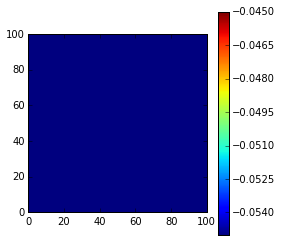

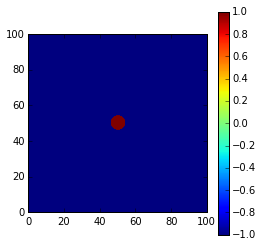

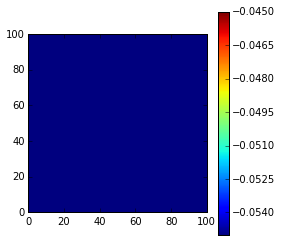

In [13]:
phase_viewer = Viewer(phase)
heat_viewer = Viewer(uu)
phase_viewer.plot()
heat_viewer.plot()

In [14]:
total_steps = 5
sweeps = 3
tolerance = 0.1

elapsed_time = 0.0
current_step = 0

while current_step < total_steps:
    uu.updateOld()
    phase.updateOld()

    res_heat0 = heat_eqn.sweep(uu, dt=dt.value, solver=solver_heat)
    res_phase0 = phase_eqn.sweep(phase, dt=dt.value, solver=solver_phase)

    for sweep in range(sweeps):
        res_heat = heat_eqn.sweep(uu, dt=dt.value, solver=solver_heat)
        res_phase = phase_eqn.sweep(phase, dt=dt.value, solver=solver_phase)

    solid_area = (np.array(phase.globalValue)>0).sum()*dx*dy # initial size of solid nucleus

    if parallelComm.procID==0:
        print
        print 'dt',dt.value
        print 'current_step',current_step
        print 'res_heat',res_heat0, res_heat
        print 'res_phase',res_phase0, res_phase
        print 'solid area', solid_area

    if (res_heat < res_heat0 * tolerance) and (res_phase < res_phase0 * tolerance):
        elapsed_time += dt.value
        current_step += 1
        dt.setValue(dt.value * 1.1)
        if current_step % 10 == 0:
            glu = uu.globalValue
            glp = phase.globalValue
            if parallelComm.procID==0:
                np.savez_compressed('data-test/dump{0}.npz'.format(current_step), uu=np.array(glu), phase=np.array(glp), elapsed_time=np.array(elapsed_time))
    else:
        dt.setValue(dt.value * 0.8)
        uu[:] == uu.old
        phase[:] = phase.old


dt 0.1
current_step 0
res_heat 0.0 0.0676351819552
res_phase 41.8008056236 0.0417830716388
solid area 50.75

dt 0.08
current_step 0
res_heat 3.03647248448 0.0530348558822
res_phase 41.8008056236 0.0291322118748
solid area 50.75

dt 0.088
current_step 1
res_heat 3.70374519218 0.0298611408946
res_phase 7.62822637987 0.017717207684
solid area 50.75

dt 0.0968
current_step 2
res_heat 1.42434742787 0.0194823863786
res_phase 2.79844957631 0.0118096638847
solid area 50.75

dt 0.10648
current_step 3
res_heat 0.833382214717 0.0127220423246
res_phase 1.65505085412 0.00758490523997
solid area 51.25

dt 0.117128
current_step 4
res_heat 0.576322634164 0.0099355956267
res_phase 1.1642327254 0.00458607068053
solid area 51.25


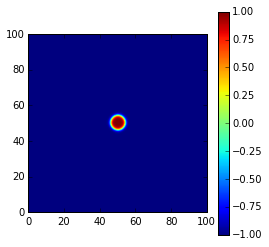

In [15]:
phase_viewer.plot()

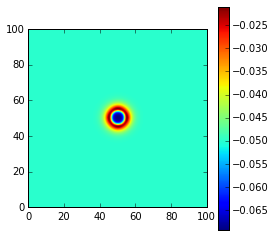

In [16]:
heat_viewer.plot()

In [1]:
# 4-fold Anisotropy video, problem 1a
# Produced using Imagemagick montage and ffmpeg:
# os.system('montage img/dump{0}_*.png -geometry +0+0 img/combo{0}.png'.format(step))
# ffmpeg -framerate 30 -pattern_type glob -i 'img/combo????.png' -c:v libx264 -r 30 -pix_fmt yuv420p Problem1a.mp4

from IPython.display import YouTubeVideo
scale = 1.5
YouTubeVideo('uG1mZTrnOFA', width=420 * scale, height=315 * scale, rel=0)

In [1]:
# 4-fold Anisotropy video, problem 1a
# Produced using Imagemagick montage and ffmpeg:
# os.system('montage img/dump{0}_*.png -geometry +0+0 img/combo{0}.png'.format(step))
# ffmpeg -framerate 30 -pattern_type glob -i 'img/combo????.png' -c:v libx264 -r 30 -pix_fmt yuv420p Problem1a.mp4

from IPython.display import YouTubeVideo
scale = 1.5
YouTubeVideo('rJ22Xyfx8F4', width=420 * scale, height=315 * scale, rel=0)